# Training a Jet Tagging with **Conv2D** 

---
In this notebook, we perform a Jet identification task using a Conv2D multiclass classifier.
The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [3]:
! git clone https://github.com/pierinim/tutorials.git

fatal: destination path 'tutorials' already exists and is not an empty directory.


In [4]:
! ls tutorials/Data/JetDataset/

jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [5]:
target = np.array([])
jetImage = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, jetImage.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 100)


The dataset consists of 50000 with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetImage, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetImage, target

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(33500, 100, 100) (16500, 100, 100) (33500, 5) (16500, 5)


In keras, images are representable as $n \times m \times k$ tensors, where $n \times m$ are the pixel dimenions and $k$ is the number of channels (e.g., 1 in a black\&while image, 3 for an RGB image). In our case, k=1. To comply to this, we add the channel index by reshaping the image dataset

In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(33500, 100, 100, 1) (16500, 100, 100, 1) (33500, 5) (16500, 5)


# Conv 2D model building

In [8]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

2024-05-13 15:33:32.013020: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 15:33:32.030580: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 15:33:32.173535: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 15:33:32.173578: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 15:33:32.174036: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [9]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
dropoutRate = 0.25

In [10]:
image_shape = (img_rows, img_cols, 1)
####
inputImage = Input(shape=(image_shape))
x = Conv2D(5, kernel_size=(5,5), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5,5))(x)
x = Dropout(dropoutRate)(x)
#
x = Conv2D(3, kernel_size=(3,3), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (3,3))(x)
x = Dropout(dropoutRate)(x)
#
x = Flatten()(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputImage, outputs=output)

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 5)       130       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 5)       20        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 100, 100, 5)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 5)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 20, 5)         0     

We now train the model

In [20]:
batch_size = 128
n_epochs = 20

In [21]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/20
262/262 - 36s - loss: 1.2356 - val_loss: 1.1594 - lr: 1.0000e-16 - 36s/epoch - 136ms/step
Epoch 2/20
262/262 - 27s - loss: 1.2367 - val_loss: 1.1595 - lr: 1.0000e-16 - 27s/epoch - 102ms/step
Epoch 3/20

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000830368326e-17.
262/262 - 30s - loss: 1.2347 - val_loss: 1.1594 - lr: 1.0000e-16 - 30s/epoch - 116ms/step
Epoch 4/20
262/262 - 37s - loss: 1.2326 - val_loss: 1.1593 - lr: 1.0000e-17 - 37s/epoch - 142ms/step
Epoch 5/20

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000664932204e-18.
262/262 - 37s - loss: 1.2355 - val_loss: 1.1595 - lr: 1.0000e-17 - 37s/epoch - 140ms/step
Epoch 6/20
262/262 - 31s - loss: 1.2363 - val_loss: 1.1594 - lr: 1.0000e-18 - 31s/epoch - 117ms/step
Epoch 7/20
262/262 - 27s - loss: 1.2336 - val_loss: 1.1590 - lr: 1.0000e-18 - 27s/epoch - 103ms/step
Epoch 8/20
262/262 - 36s - loss: 1.2347 - val_loss: 1.1590 - lr: 1.0000e-18 - 36s/epoch - 139ms/step
Epoch 9/20

Epoch 9: ReduceLROnPlate

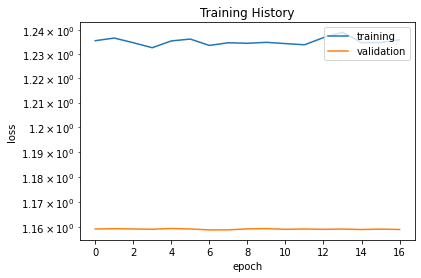

In [22]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [23]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

516/516 [==============================] - 3s 6ms/step


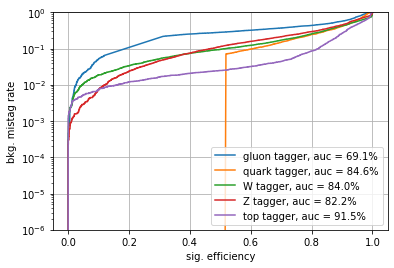

In [24]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

In [25]:
## Plot probabilty for each of the taggers

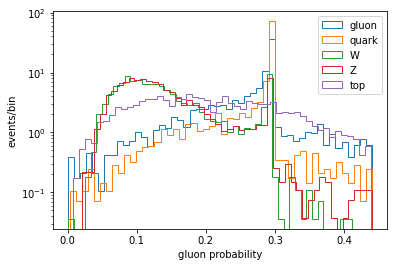

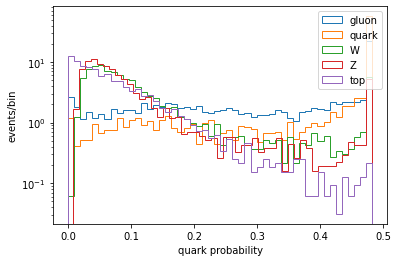

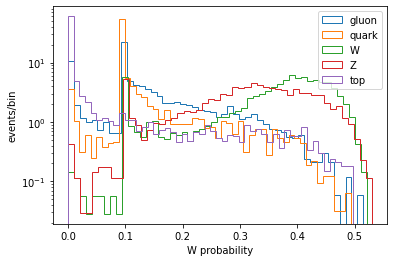

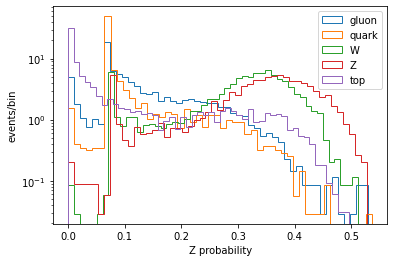

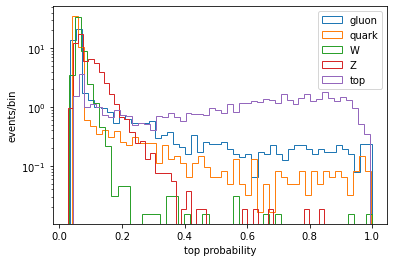

In [26]:
df1=pd.DataFrame()
for i, label in enumerate(labels):
    df1[label] = y_val[:,i]
    df1[label + '_pred'] = predict_val[:,i]
for i, label in enumerate(labels):
    labp=label + '_pred'
    for j, label in enumerate(labels):
       plt.hist(df1.query(label+'==1')[labp],50,density=True, histtype='step',label=label)
    plt.semilogy()
    plt.xlabel(labels[i]+' probability')
    plt.ylabel("events/bin")
    plt.legend(loc='best')
    plt.show()        